In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import mean_squared_error

import shap
import joblib

plt.style.use("seaborn-v0_8-muted")

In [42]:
data_path = Path("../data/processed/cleaned_gravity_speed_data.csv")
model_path = Path("../models/rf_model.joblib")

df = pd.read_csv(data_path, on_bad_lines='skip')
model = joblib.load(model_path)

In [43]:
df.head()

,mass_kg,radius_m,velocity_m_s,gravitational_dilation,velocity_dilation,combined_dilation,time_far_s,time_near_s,time_difference_s
0,6.620184e+29,5.356206e+09,8.128375e+07,1.0,1.038859,0.962595,1.0,0.962595,0.037405
1,8.862898e+29,8.749384e+09,1.207812e+08,1.0,1.092449,0.915374,1.0,0.915374,0.084626
2,2.994138e+29,2.869731e+09,6.245075e+07,1.0,1.022398,0.978093,1.0,0.978093,0.021907
3,4.302086e+29,6.169629e+09,1.997366e+08,1.0,1.340231,0.746140,1.0,0.746140,0.253860
4,3.116746e+29,2.609683e+09,1.579006e+08,1.0,1.176087,0.850277,1.0,0.850277,0.149723


In [44]:
df = df.apply(pd.to_numeric, errors='coerce')
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)

print(f"✅ Data shape: {df.shape}")

✅ Data shape: (1000, 9)


In [45]:
target = "combined_dilation"
X = df.drop(columns=[target])
y = df[target]

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

joblib.dump(model, "../models/rf_model.joblib")

['../models/rf_model.joblib']

In [47]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📊 RMSE of Random Forest: {rmse:.4f}")


📊 RMSE of Random Forest: 0.0005


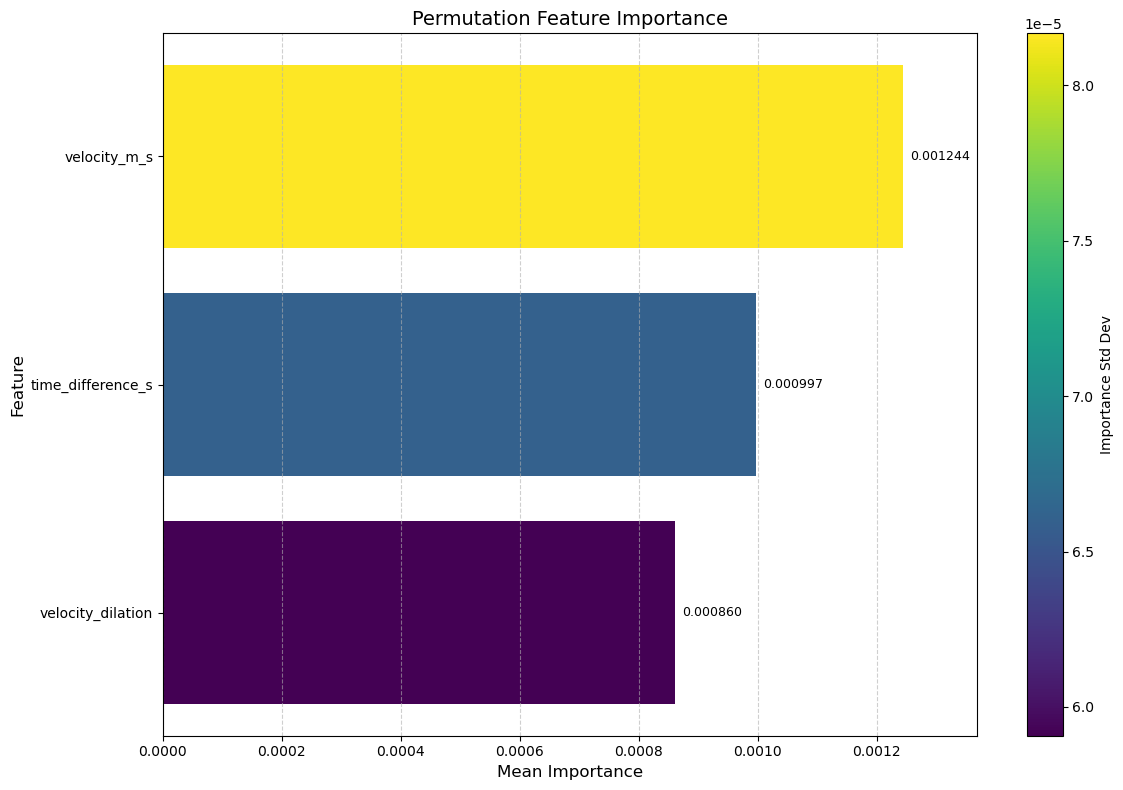

In [ ]:
excluded_features = ["mass_kg", "radius_m", "gravitational_dilation", "time_far_s", "time_near_s"]

perm_result = permutation_importance(
    model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="neg_mean_squared_error"
)

importances_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std
})

importances_df = importances_df[~importances_df["feature"].isin(excluded_features)]
importances_df["importance_mean"] = importances_df["importance_mean"].clip(lower=1e-6)
importances_df = importances_df.sort_values(by="importance_mean", ascending=True)

norm = plt.Normalize(importances_df["importance_std"].min(), importances_df["importance_std"].max())
colors = plt.cm.viridis(norm(importances_df["importance_std"]))

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(
    importances_df["feature"],
    importances_df["importance_mean"],
    color=colors
)

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Importance Std Dev")

for bar, value in zip(bars, importances_df["importance_mean"]):
    plt.text(value + importances_df["importance_mean"].max() * 0.01,
             bar.get_y() + bar.get_height() / 2,
             f"{value:.6f}", va="center", ha="left", fontsize=9)

plt.title("Permutation Feature Importance", fontsize=14)
plt.xlabel("Mean Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xlim(0, importances_df["importance_mean"].max() * 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("../reports/figures/permutation_importance.png", dpi=300)
plt.show()


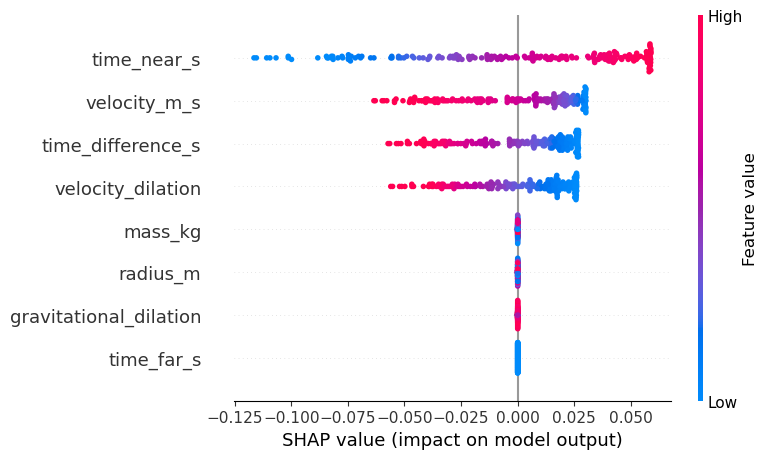

In [49]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [50]:
shap.initjs()
shap.plots.force(shap_values[0])

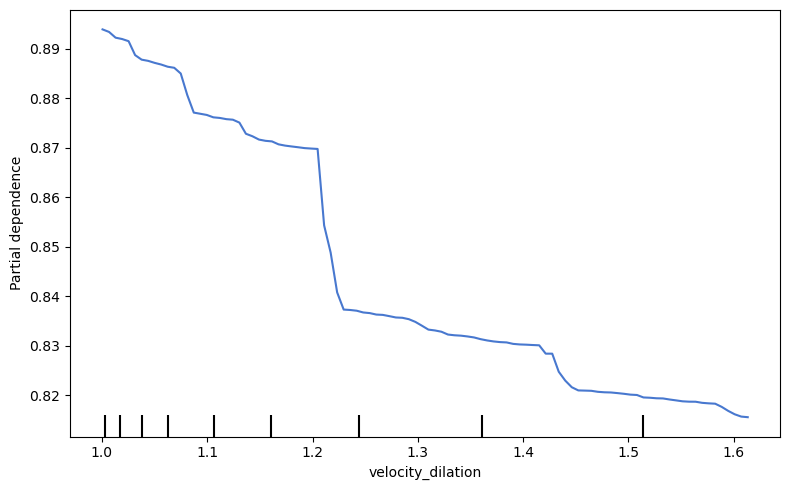

In [51]:
top_feature = importances_df["feature"].iloc[0]

fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(model, X, [top_feature], ax=ax)
plt.tight_layout()
plt.show()